# MLP
Mean RCI over 14 cell lines.

This notebook uses
mRNA, longest, no middle-exclusion train, no middle-exclusion test, 0 threshold, learning module, cross-validation.

In [1]:
SEED = 45
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-05-01 13:02:29.598287


In [2]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP_mRNA'
SAVE_DESCRIM_FILENAME = None # 'GMM_mRNA'
LOAD_MODEL_FILENAME = None # 'MLP_mRNA.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM_mRNA.0.0.pickle'

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = 0  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -1   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         =  1   #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.pc_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.pc_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.longest_pc_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.longest_pc_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [6]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-05-01 13:02:51.335066
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.all_cell_lines.csv
Number of RCI values loaded 13663
Num RCI: 13663
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.longest_pc_transcripts.csv
Loaded 13663 sequences.

Training # 1 1
2023-05-01 13:03:52.950230
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.1.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5766:5164 52.75%
Computed class weights: {0: 1.058288148721921, 1: 0.947797433229275}
Valid 1:0 1402:1331 51.30%
FIT


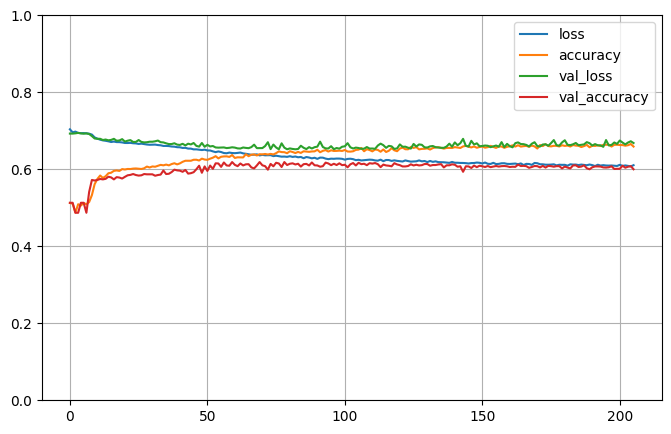


Testing # 1 1
2023-05-01 13:11:17.806437
PREDICT
Test 1:0 1402:1331 51.30%
Predict 1:0 1407:1326 51.48%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.5064164 mean 0.17962329 std
Range of scores: 0.12667598 to 0.96413505
Score threshold 0.5
Confusion matrix
 [[805 526]
 [521 881]]
Normalized matrix
 [[0.29454812 0.1924625 ]
 [0.190633   0.32235638]]
Extreme scores correct, pos:neg 465 431
Extreme scores incorrect pos:neg 184 211


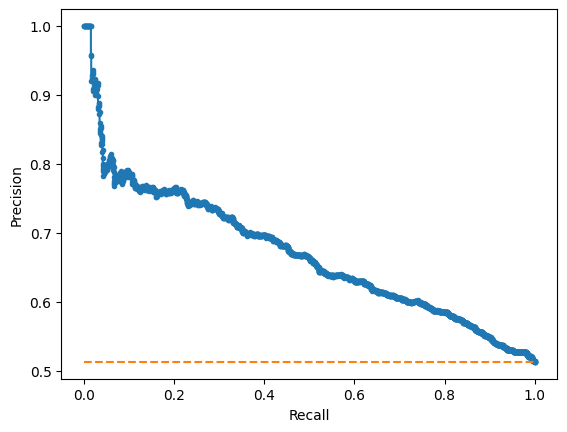

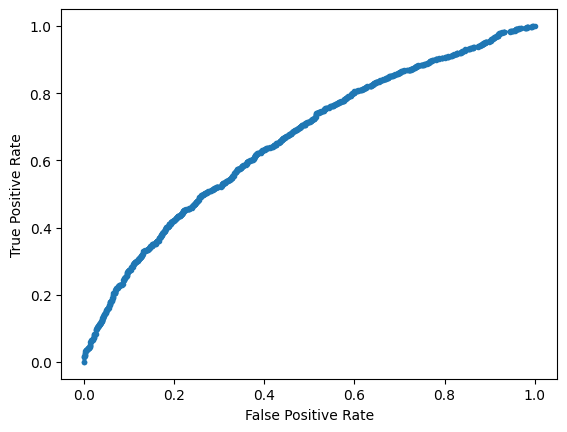

Accuracy: 61.69% Precision: 62.62% Recall: 62.84%
F1: 62.73% MCC: 0.2332
AUPRC: 66.99% AUROC: 66.14%
 accuracy [61.690450054884735]
 precision [62.61549395877755]
 recall [62.83880171184023]
 F1 [62.72694909220364]
 MCC [0.23322017922779073]
 AUPRC [66.99124795087357]
 AUROC [66.14137150855652]

Training # 1 2
2023-05-01 13:11:18.895917
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.2.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5693:5237 52.09%
Computed class weights: {0: 1.0435363757876648, 1: 0.9599508167925522}
Valid 1:0 1475:1258 53.97%
FIT


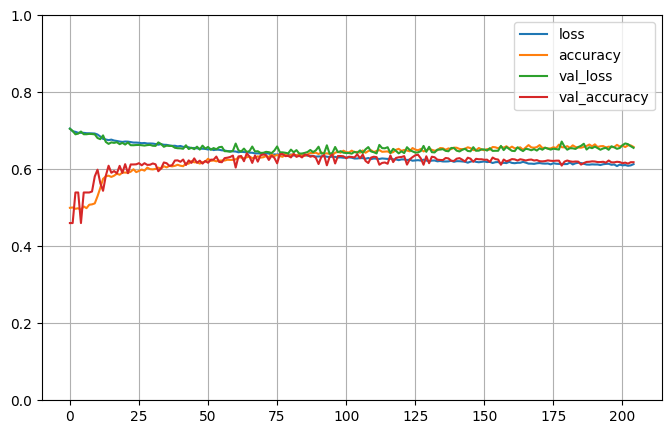


Testing # 1 2
2023-05-01 13:18:17.893572
PREDICT
Test 1:0 1475:1258 53.97%
Predict 1:0 1478:1255 54.08%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.5111222 mean 0.16985805 std
Range of scores: 0.10026922 to 0.9390008
Score threshold 0.5
Confusion matrix
 [[763 495]
 [492 983]]
Normalized matrix
 [[0.27918039 0.18111965]
 [0.18002195 0.35967801]]
Extreme scores correct, pos:neg 468 385
Extreme scores incorrect pos:neg 148 183


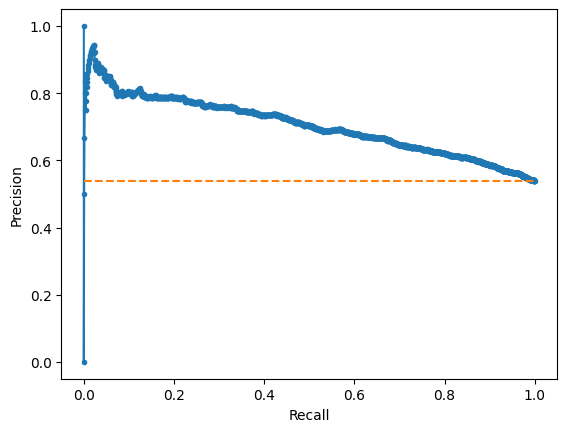

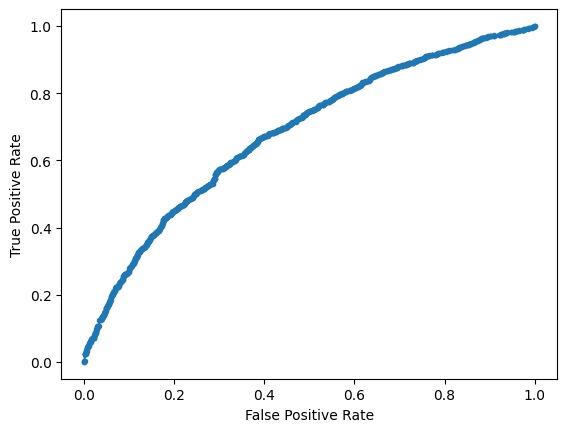

Accuracy: 63.89% Precision: 66.51% Recall: 66.64%
F1: 66.58% MCC: 0.2730
AUPRC: 70.29% AUROC: 68.10%
 accuracy [63.88583973655324]
 precision [66.50879566982408]
 recall [66.64406779661017]
 F1 [66.57636302065697]
 MCC [0.2730075182526421]
 AUPRC [70.29441465730253]
 AUROC [68.09641346231577]

Training # 1 3
2023-05-01 13:18:18.790528
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.3.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5720:5210 52.33%
Computed class weights: {0: 1.0489443378119, 1: 0.9554195804195804}
Valid 1:0 1448:1285 52.98%
FIT


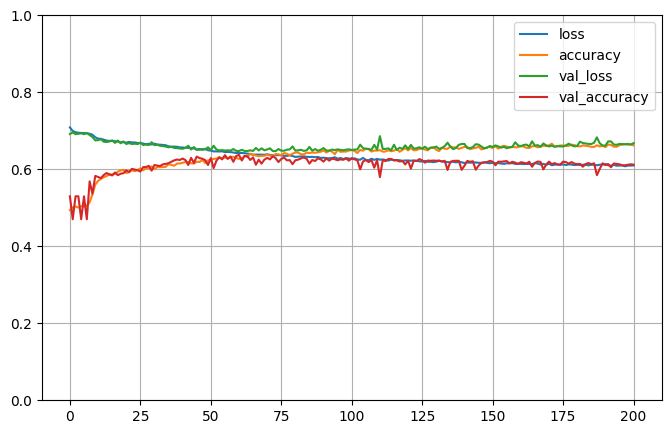


Testing # 1 3
2023-05-01 13:25:43.120261
PREDICT
Test 1:0 1448:1285 52.98%
Predict 1:0 1670:1063 61.11%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.5469177 mean 0.17424124 std
Range of scores: 0.14932731 to 0.9685031
Score threshold 0.5
Confusion matrix
 [[ 667  618]
 [ 396 1052]]
Normalized matrix
 [[0.24405415 0.22612514]
 [0.14489572 0.38492499]]
Extreme scores correct, pos:neg 574 300
Extreme scores incorrect pos:neg 257 144


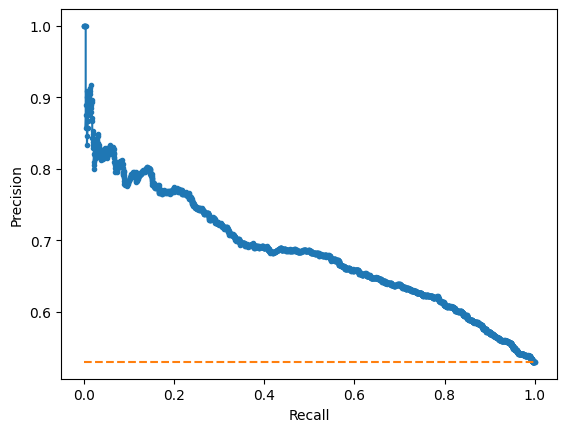

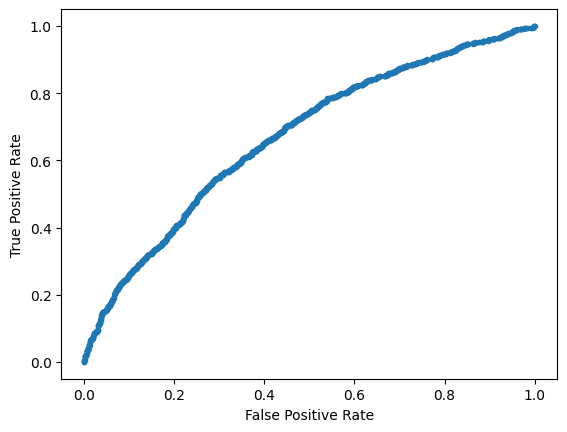

Accuracy: 62.90% Precision: 62.99% Recall: 72.65%
F1: 67.48% MCC: 0.2514
AUPRC: 68.35% AUROC: 66.92%
 accuracy [62.89791437980241]
 precision [62.9940119760479]
 recall [72.65193370165746]
 F1 [67.47915330339961]
 MCC [0.25142801781991797]
 AUPRC [68.35005115248933]
 AUROC [66.92058817206613]

Training # 1 4
2023-05-01 13:25:43.927606
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.4.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5770:5161 52.79%
Computed class weights: {0: 1.059000193760899, 1: 0.9472270363951473}
Valid 1:0 1398:1334 51.17%
FIT


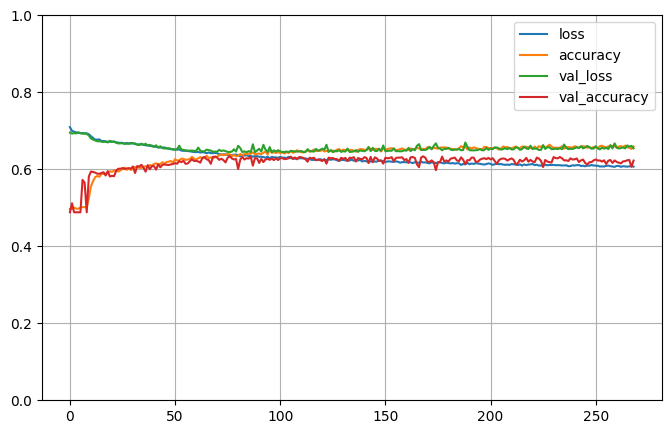


Testing # 1 4
2023-05-01 13:36:07.916970
PREDICT
Test 1:0 1398:1334 51.17%
Predict 1:0 1239:1493 45.35%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.48467857 mean 0.18812305 std
Range of scores: 0.1024533 to 0.9851144
Score threshold 0.5
Confusion matrix
 [[913 421]
 [580 818]]
Normalized matrix
 [[0.33418741 0.15409956]
 [0.21229868 0.29941435]]
Extreme scores correct, pos:neg 404 499
Extreme scores incorrect pos:neg 134 247


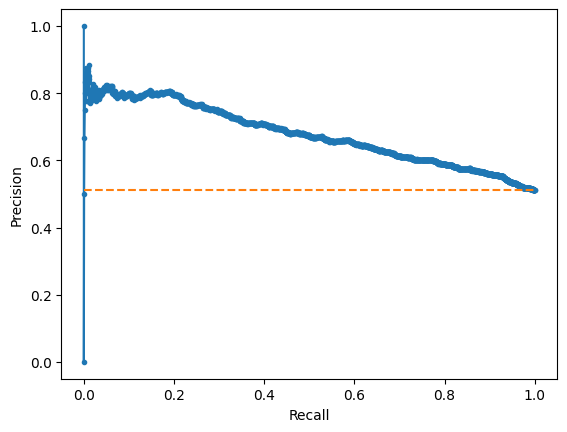

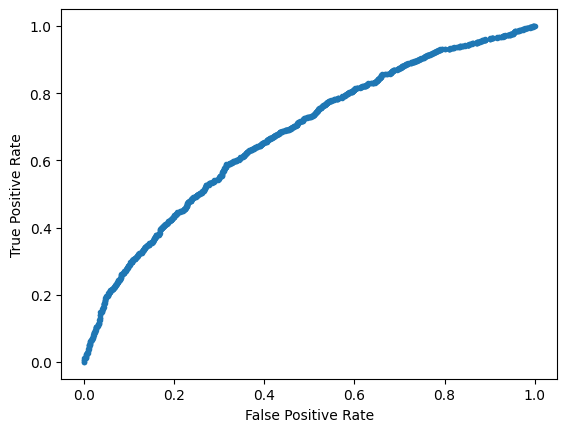

Accuracy: 63.36% Precision: 66.02% Recall: 58.51%
F1: 62.04% MCC: 0.2706
AUPRC: 67.76% AUROC: 67.66%
 accuracy [63.360175695461194]
 precision [66.02098466505247]
 recall [58.51216022889842]
 F1 [62.04019719378081]
 MCC [0.27062759953664295]
 AUPRC [67.76054797219884]
 AUROC [67.65994685060903]

Training # 1 5
2023-05-01 13:36:08.928975
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.5.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5723:5208 52.36%
Computed class weights: {0: 1.0494431643625193, 1: 0.9550061156735977}
Valid 1:0 1445:1287 52.89%
FIT


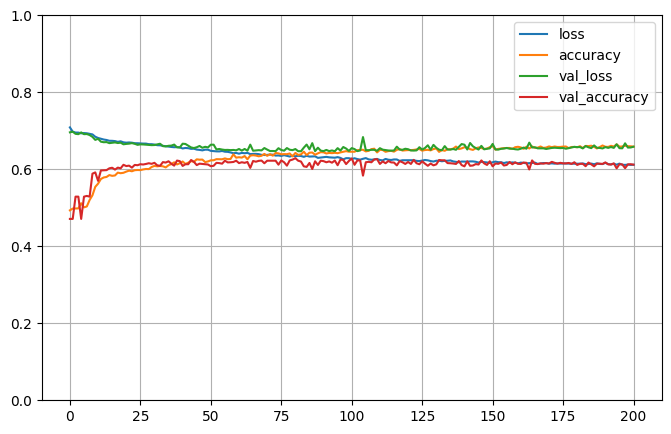


Testing # 1 5
2023-05-01 13:43:04.146463
PREDICT
Test 1:0 1445:1287 52.89%
Predict 1:0 1787:945 65.41%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.5751524 mean 0.18173176 std
Range of scores: 0.119097605 to 0.967942
Score threshold 0.5
Confusion matrix
 [[ 608  679]
 [ 337 1108]]
Normalized matrix
 [[0.22254758 0.24853587]
 [0.12335286 0.40556369]]
Extreme scores correct, pos:neg 730 259
Extreme scores incorrect pos:neg 345 127


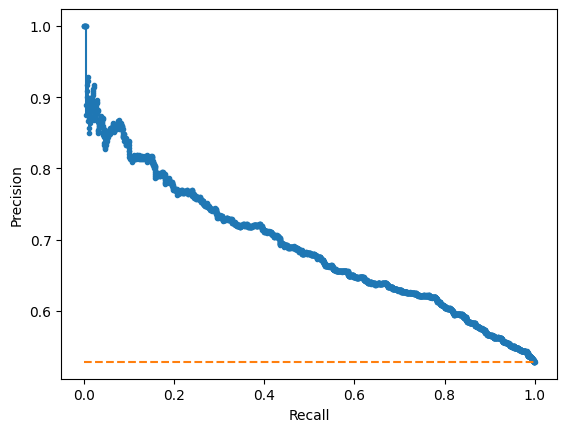

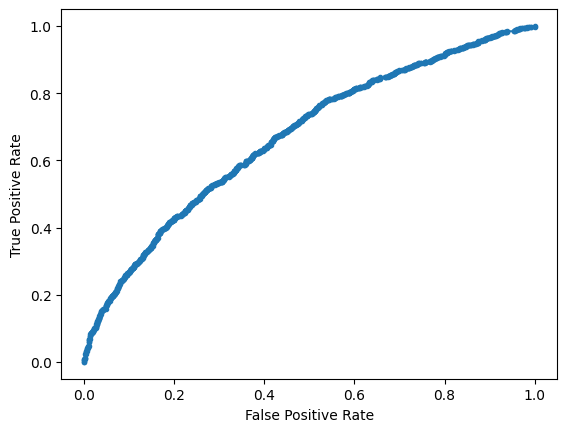

Accuracy: 62.81% Precision: 62.00% Recall: 76.68%
F1: 68.56% MCC: 0.2510
AUPRC: 69.05% AUROC: 66.95%
 accuracy [62.811127379209374]
 precision [62.00335758254057]
 recall [76.67820069204151]
 F1 [68.56435643564357]
 MCC [0.25101717109119115]
 AUPRC [69.05362944599842]
 AUROC [66.95079622415263]

Training # 2 1
2023-05-01 13:43:04.919851
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.1.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5739:5191 52.51%
Computed class weights: {0: 1.0527836640339048, 1: 0.9522564906778185}
Valid 1:0 1429:1304 52.29%
FIT


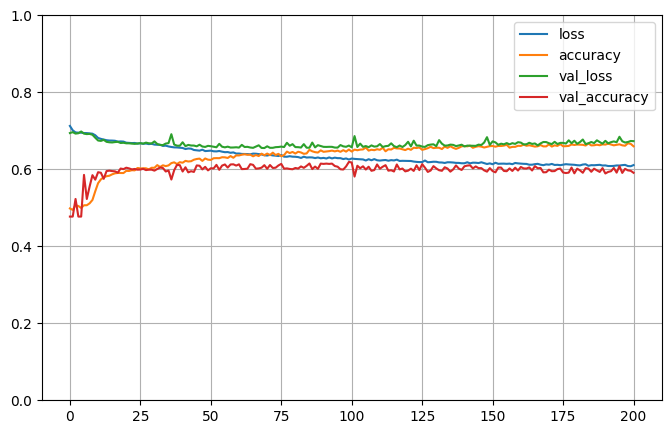


Testing # 2 1
2023-05-01 13:50:28.757164
PREDICT
Test 1:0 1429:1304 52.29%
Predict 1:0 1632:1101 59.71%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.5405248 mean 0.16903614 std
Range of scores: 0.15960252 to 0.9743414
Score threshold 0.5
Confusion matrix
 [[ 680  624]
 [ 421 1008]]
Normalized matrix
 [[0.24881083 0.22832053]
 [0.15404318 0.36882547]]
Extreme scores correct, pos:neg 545 297
Extreme scores incorrect pos:neg 236 144


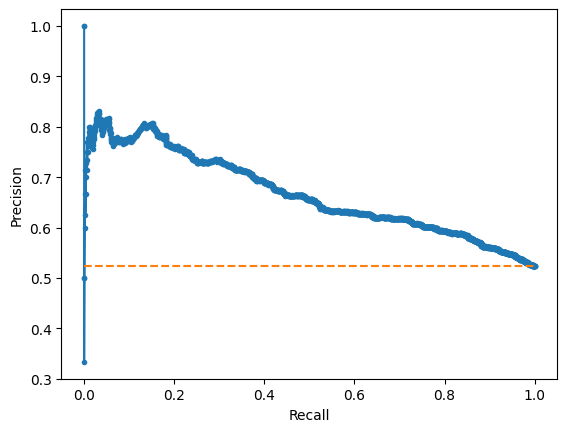

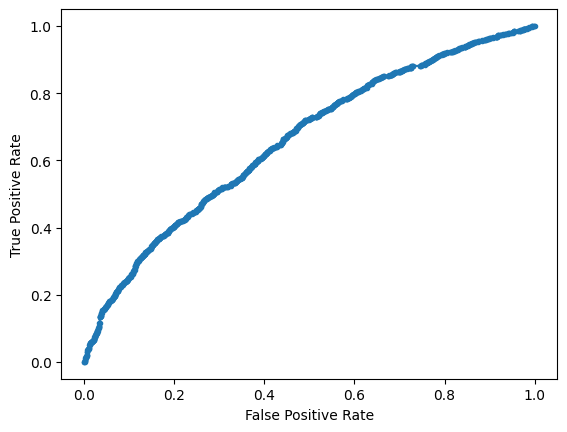

Accuracy: 61.76% Precision: 61.76% Recall: 70.54%
F1: 65.86% MCC: 0.2310
AUPRC: 66.73% AUROC: 65.75%
 accuracy [61.76362971094036]
 precision [61.76470588235294]
 recall [70.53883834849545]
 F1 [65.8608297941849]
 MCC [0.2310258553923885]
 AUPRC [66.72543971511773]
 AUROC [65.75037458087728]

Training # 2 2
2023-05-01 13:50:29.753118
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.2.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5748:5182 52.59%
Computed class weights: {0: 1.054612118873022, 1: 0.9507654836464857}
Valid 1:0 1420:1313 51.96%
FIT


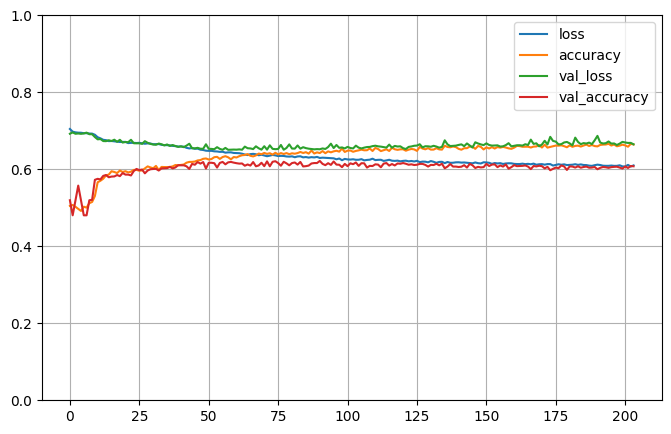


Testing # 2 2
2023-05-01 13:57:20.333477
PREDICT
Test 1:0 1420:1313 51.96%
Predict 1:0 1599:1134 58.51%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.53962624 mean 0.19837636 std
Range of scores: 0.11604802 to 0.9680128
Score threshold 0.5
Confusion matrix
 [[701 612]
 [433 987]]
Normalized matrix
 [[0.25649469 0.22392975]
 [0.15843396 0.3611416 ]]
Extreme scores correct, pos:neg 624 375
Extreme scores incorrect pos:neg 283 190


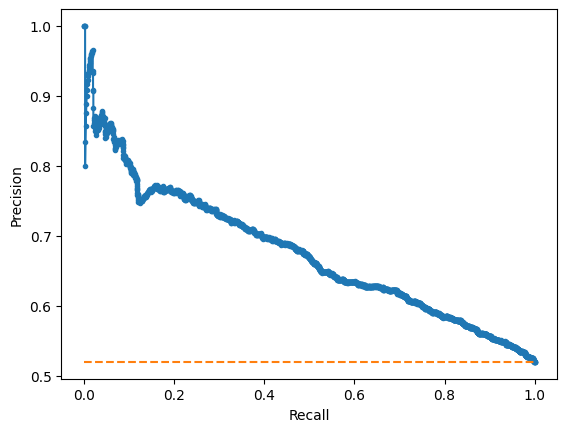

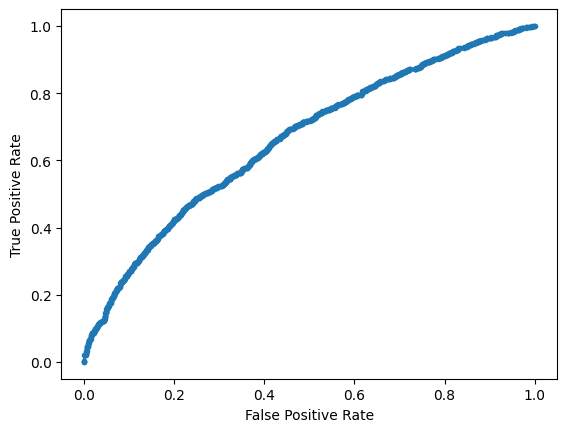

Accuracy: 61.76% Precision: 61.73% Recall: 69.51%
F1: 65.39% MCC: 0.2322
AUPRC: 67.62% AUROC: 66.16%
 accuracy [61.76362971094036]
 precision [61.72607879924953]
 recall [69.50704225352112]
 F1 [65.38588936734018]
 MCC [0.23217192616575189]
 AUPRC [67.6217510487057]
 AUROC [66.16323224955215]

Training # 2 3
2023-05-01 13:57:21.785051
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.3.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5690:5240 52.06%
Computed class weights: {0: 1.04293893129771, 1: 0.960456942003515}
Valid 1:0 1478:1255 54.08%
FIT


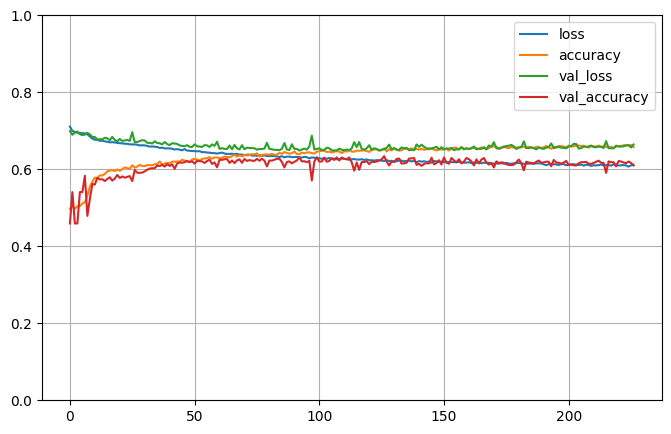


Testing # 2 3
2023-05-01 14:05:45.591496
PREDICT
Test 1:0 1478:1255 54.08%
Predict 1:0 1654:1079 60.52%
Test sizes (2733, 1025) (2733,)
Distrib of scores: 0.5602867 mean 0.18388829 std
Range of scores: 0.14344826 to 0.9828044
Score threshold 0.5
Confusion matrix
 [[ 667  588]
 [ 412 1066]]
Normalized matrix
 [[0.24405415 0.21514819]
 [0.15075009 0.39004757]]
Extreme scores correct, pos:neg 677 279
Extreme scores incorrect pos:neg 287 137


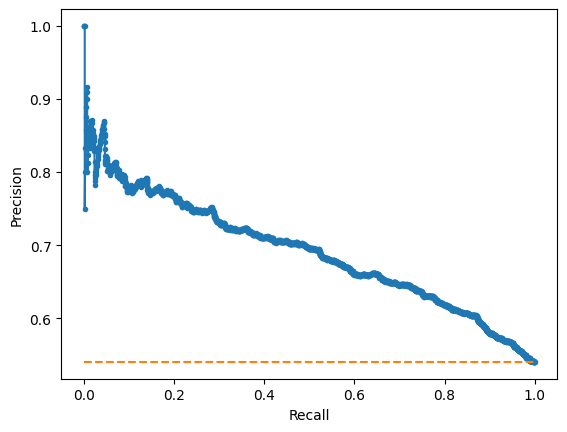

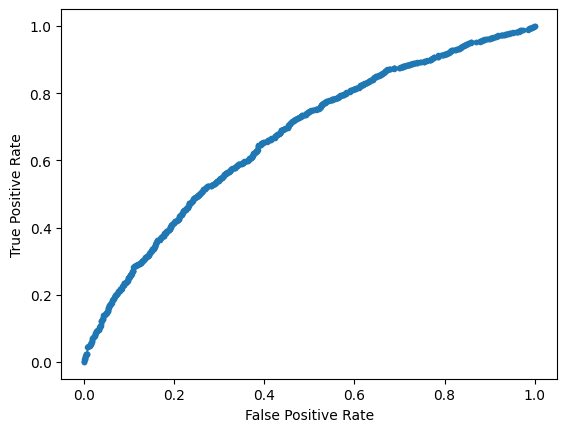

Accuracy: 63.41% Precision: 64.45% Recall: 72.12%
F1: 68.07% MCC: 0.2576
AUPRC: 69.08% AUROC: 67.01%
 accuracy [63.41017197219173]
 precision [64.44981862152358]
 recall [72.12449255751014]
 F1 [68.07151979565774]
 MCC [0.2576431198752009]
 AUPRC [69.08460044425924]
 AUROC [67.01300346651283]

Training # 2 4
2023-05-01 14:05:46.364128
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.4.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5718:5213 52.31%
Computed class weights: {0: 1.048436600805678, 1: 0.9558412032179083}
Valid 1:0 1450:1282 53.07%
FIT


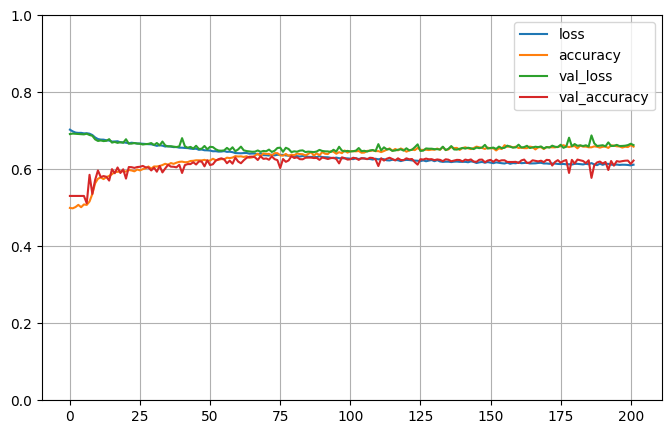


Testing # 2 4
2023-05-01 14:13:10.160910
PREDICT
Test 1:0 1450:1282 53.07%
Predict 1:0 1489:1243 54.50%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.5139842 mean 0.1748892 std
Range of scores: 0.11717312 to 0.9653182
Score threshold 0.5
Confusion matrix
 [[757 525]
 [486 964]]
Normalized matrix
 [[0.27708638 0.19216691]
 [0.17789165 0.35285505]]
Extreme scores correct, pos:neg 489 373
Extreme scores incorrect pos:neg 174 201


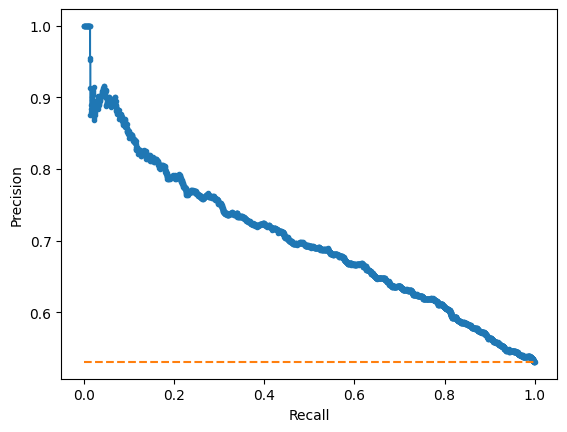

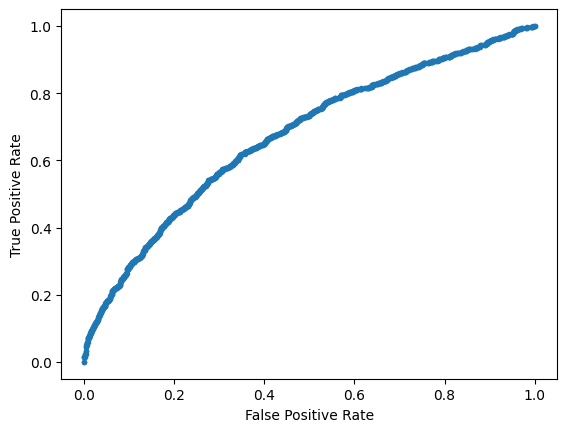

Accuracy: 62.99% Precision: 64.74% Recall: 66.48%
F1: 65.60% MCC: 0.2559
AUPRC: 70.09% AUROC: 67.26%
 accuracy [62.994143484626655]
 precision [64.74143720617865]
 recall [66.48275862068965]
 F1 [65.60054440285812]
 MCC [0.2558674122303751]
 AUPRC [70.08912670773111]
 AUROC [67.26230566464038]

Training # 2 5
2023-05-01 14:13:10.937500
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.5.validation_genes.txt
Discriminator ZERO 0
Train 1:0 5777:5154 52.85%
Computed class weights: {0: 1.0604384943733023, 1: 0.9460792799030638}
Valid 1:0 1391:1341 50.92%
FIT


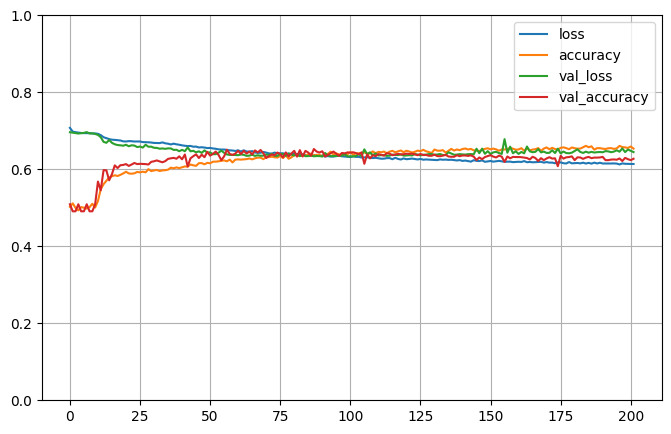


Testing # 2 5
2023-05-01 14:20:00.566154
PREDICT
Test 1:0 1391:1341 50.92%
Predict 1:0 1419:1313 51.94%
Test sizes (2732, 1025) (2732,)
Distrib of scores: 0.5070865 mean 0.16689003 std
Range of scores: 0.11933907 to 0.93697786
Score threshold 0.5
Confusion matrix
 [[841 500]
 [472 919]]
Normalized matrix
 [[0.30783309 0.18301611]
 [0.1727672  0.3363836 ]]
Extreme scores correct, pos:neg 437 424
Extreme scores incorrect pos:neg 161 155


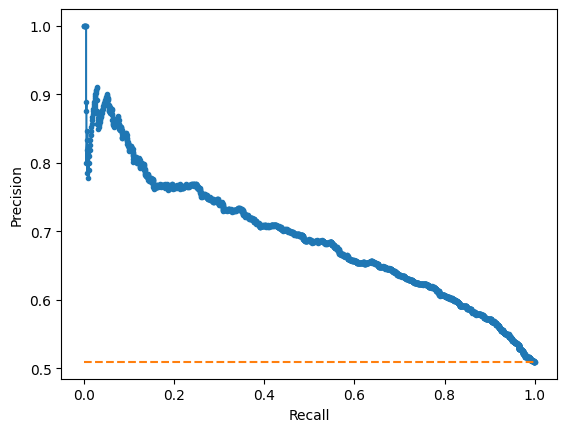

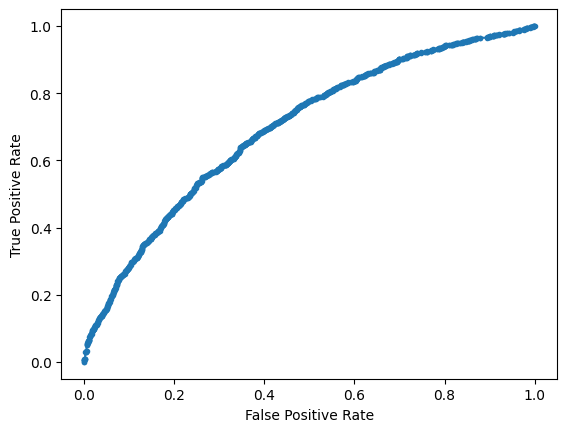

Accuracy: 64.42% Precision: 64.76% Recall: 66.07%
F1: 65.41% MCC: 0.2880
AUPRC: 69.09% AUROC: 69.52%
 accuracy [64.42166910688141]
 precision [64.76391825229034]
 recall [66.06757728253055]
 F1 [65.40925266903915]
 MCC [0.28798833846204824]
 AUPRC [69.09231677240989]
 AUROC [69.51758159811851]
2023-05-01 14:20:01.510380


In [7]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator('pc')  # use pc filename prefix for mRNA
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [8]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 62.90% std 0.93
 precision mean 63.76% std 1.77
 recall mean 68.20% std 5.24
 F1 mean 65.77% std 2.11
 MCC mean 0.2544 std 0.0190
 AUPRC mean 68.51% std 1.23
 AUROC mean 67.15% std 1.10
 accuracy [[61.690450054884735], [63.88583973655324], [62.89791437980241], [63.360175695461194], [62.811127379209374], [61.76362971094036], [61.76362971094036], [63.41017197219173], [62.994143484626655], [64.42166910688141]]
 precision [[62.61549395877755], [66.50879566982408], [62.9940119760479], [66.02098466505247], [62.00335758254057], [61.76470588235294], [61.72607879924953], [64.44981862152358], [64.74143720617865], [64.76391825229034]]
 recall [[62.83880171184023], [66.64406779661017], [72.65193370165746], [58.51216022889842], [76.67820069204151], [70.53883834849545], [69.50704225352112], [72.12449255751014], [66.48275862068965], [66.06757728253055]]
 F1 [[62.72694909220364], [66.57636302065697], [67.47915330339961], [62.04019719378081], [68.56435643564357], [65.8608297941849], [65.